# Classification Models: Natural Language Processing (NLP): Emails Spam

## HIGHLIGHTS:

The following will be done:

1. Prepare Data:

    * Import data
    * Explore data: Assess, clean and re-assess data
    * Split data:
    
2. Build Model:

    * Baseline
    * Iterate/ Train model
    * Evaluate Model

3. Communicate Result

    * Save model

**`Dataset:`**

The dataset for this analysis is found here @ [emails](https://drive.google.com/file/d/16xAFRuL6GVt4C60k2iZPJ2DiW6Bu4thV/view?usp=sharing)


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Import pickle for saving model
import  pickle

# COllections
from collections import Counter

# Import NLP package
import string
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud


# Model selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (train_test_split, cross_validate)
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Model evaluation
from sklearn.metrics import (roc_auc_score, roc_curve, classification_report,confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score, log_loss, precision_score,
                             recall_score, auc, RocCurveDisplay)

# For feature preprocessing, normalizing and extraction
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%matplotlib inline


In [60]:
# Make some downloads from nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\IKECHUKWU\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\IKECHUKWU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\IKECHUKWU\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\IKECHUKWU\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\IKECHUKWU\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\IKECHUKWU\AppData\Roaming\nltk_data...
[nltk_data]   Pack

True

In [72]:
# stopwords.words("english")

In [2]:
# Define relavant functions for further analysis

# Define a function to load dataset
def wrangle_data(filename: str, sep =","):
    # Load data
    data = pd.read_csv(filename, sep=sep)

    # Subset data
    data = data.iloc[: , :2]

    # Remove duplicate
    data = data.copy()
    data.drop_duplicates(inplace=True)

    # Remove whitespace from 2nd column
    data["spam"] = data["spam"].str.strip()

    # Drop rows with string data from 2nd column by masking
    mask = ((data["spam"]!="its termination would not  have such a phenomenal impact on the power situation .  however")
            & (data["spam"]!="mr suresh prabhu"))
    data = data[mask]

    # Change datatype to int for label variable
    data["spam"] = data["spam"].astype(int)

    # Return clean data
    return data


# Define tokenized function
# Note that 's' stands for strings and 't' stands for text
def process_text(s):
    # Remove punctuation marks from text
    nopunc = [t for t in s if t not in string.punctuation]
    # Concatenating string characters together
    nopunc = "".join(nopunc)

    # Remove stopwords. Change all string characters to lowercase
    clean_word = [w for w in nopunc.split() if w.lower() not in stopwords.words("english")]

    # Returning clean data
    return clean_word


# Define function that compares predicted label and actual value
def predicted_result(y_true: np.ndarray, y_pred: np.ndarray) -> pd.DataFrame:
    """Returns new pandas dataframe containing true and predicted labels
    
    Params:
    y_true -- np.ndarray, the initial target variable
    y_pred - np.ndarray, the predicted target variable
    Return: Pandas Dataframe of the true and predicted target variables
    """
    result = pd.DataFrame()
    result["y_true"] = y_true
    result["y_pred"] = y_pred
    result["error_term"] = (y_true - y_pred)

    return result


# Define function predicting label variable
def predict_label(X, model) -> "np.ndarray":
    """Returns the predicted series label
    
    Params:
    X -- pd.DataFrame, inputs the feature variables
    model_type -- inputs the model type

    Return: The predicted label variable as pandas Series object 
    """
    y_pred = model.predict(X)
    return y_pred


# Define function for Confusion matrix
def confusion_mat(model, X, y, model_name):
    ConfusionMatrixDisplay.from_estimator(model, X, y)
    plt.title(f"Confusion Matrix: {model_name.title()}")
    # plt.savefig(f"Confusion_mat_{model_name}.jpg", bbox_inches='tight', dpi=150);

# Define function to predict probability
def proba_test_score(model, X):
    y_proba = model.predict_proba(X)[: ,1]
    return y_proba


# Define function to get the ROC curve and AUC
def get_auc_roc_curve(y, y_proba, model_name:str):
    fpr, tpr, thresholds = roc_curve(y_true=y, y_score=y_proba)
    roc_auc = auc(fpr, tpr)
    # Plot the ROC curve
    plt.plot(fpr, tpr, label= f'ROC curve area={round(roc_auc,2)}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic (ROC) curve: {model_name.title()}')
    plt.legend(loc="lower right")
    # plt.savefig(f"auc_roc_curve_{model_name}.jpg", bbox_inches='tight', dpi=150);


# Define function that saves model as file
def save_model(model, filename: str):
    with open(filename, "wb") as file:
        pickle.dump(model, file)


# Define function to get the model metrics
def eval_metrics(y_true, y_pred, y_proba):

    acc_score = accuracy_score(y_true=y_true, y_pred=y_pred)
    prec_score = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    entropy = log_loss(y_true=y_true, y_pred=y_proba)
    return (
        {
        "accuracy":round(acc_score, 4),
        "precision":round(prec_score, 4),
        "recall":round(recall, 4),
        "entropy":round(entropy, 4)
        }
    )
    

# Define function for model selection
def eval_best_model(model_1, model_2,model_3,model_4,model_5,model_6,
                    X_train, X_test, y_train, y_test):
    for m in [model_1, model_2,model_3,model_4,model_5,model_6]:
        train_acc = m.score(X_train, y_train)
        test_acc = m.score(X_test, y_test)
        # Print accuracy scores
        print(f"Model accuracy for:{m}")
        print(f"Training Accuracy: {round(train_acc, 4)}")
        print(f"Test Accuracy: {round(test_acc, 4)}")
        print("="*50)



# Define function to plot most frequent words on wordcloud
def plot_freq_word(data: pd.DataFrame, feature: str, title):
    # Plot the frequent word on wordcloud
    plt.figure(figsize=[10,5])
    wordcld = WordCloud().generate(str(data[feature]))
    plt.xlabel(f"{feature}")
    plt.ylabel("Frequency")
    plt.title(f"Plot of {title}")
    plt.imshow(wordcld);


# Define a function for the bag of words
def text_bow(txt):
    txt_counter = Counter(txt)
    return txt_counter  


## Prepare Data

### Import and Wrangle data

In [3]:
# Load dataset
df = wrangle_data("emails_.csv")
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
# Investigate dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5693 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5693 non-null   object
 1   spam    5693 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 111.2+ KB


In [5]:
# Check for missing values
df.isna().sum()

text    0
spam    0
dtype: int64

In [6]:
# Check for duplicates
df.duplicated().sum()

0

In [7]:
# Checking the spam label
df["spam"].value_counts()

0    4326
1    1367
Name: spam, dtype: int64

In [8]:
# Tokenize data
df["text"].head().apply(process_text)

0    [Subject, naturally, irresistible, corporate, ...
1    [Subject, stock, trading, gunslinger, fanny, m...
2    [Subject, unbelievable, new, homes, made, easy...
3    [Subject, 4, color, printing, special, request...
4    [Subject, money, get, software, cds, software,...
Name: text, dtype: object

### Preprocess data

In [9]:
# Tokenize a word
example = df["text"][20]
tokenizer  = word_tokenize(example)
tokenizer[:10]

['Subject', ':', 'any', 'med', 'for', 'your', 'girl', 'to', 'be', 'happy']

In [10]:
# Investigate the part of speech
tagged = nltk.pos_tag(tokenizer)
tagged[:10]

[('Subject', 'JJ'),
 (':', ':'),
 ('any', 'DT'),
 ('med', 'VBD'),
 ('for', 'IN'),
 ('your', 'PRP$'),
 ('girl', 'NN'),
 ('to', 'TO'),
 ('be', 'VB'),
 ('happy', 'JJ')]

In [11]:
# Putting the pos and tokens side-by-side
items = nltk.chunk.ne_chunk(tagged)
items.pprint()

(S
  (GPE Subject/JJ)
  :/:
  any/DT
  med/VBD
  for/IN
  your/PRP$
  girl/NN
  to/TO
  be/VB
  happy/JJ
  !/.
  your/PRP$
  girl/NN
  is/VBZ
  unsatisfied/JJ
  with/IN
  your/PRP$
  potency/NN
  ?/.
  don/NN
  '/''
  t/JJ
  wait/NN
  until/IN
  she/PRP
  finds/VBZ
  another/DT
  men/NNS
  !/.
  click/NN
  here/RB
  to/TO
  choose/VB
  from/IN
  a/DT
  great/JJ
  variety/NN
  of/IN
  llcensed/JJ
  love/NN
  t/NN
  @/NNP
  bs/NN
  !/.
  best/JJS
  pri/JJ
  $/$
  es/NN
  ,/,
  fast/JJ
  shippinq/NN
  and/CC
  guaranteed/JJ
  effect/NN
  !/.
  here/RB
  you/PRP
  buy/VBP
  it/PRP
  riqht/VBZ
  from/IN
  warehouse/NN
  !/.
  the/DT
  store/NN
  is/VBZ
  verified/VBN
  by/IN
  bbb/NN
  and/CC
  approved/VBN
  by/IN
  visa/NN
  !/.)


### Preprocess data

In [12]:
# Get the vectorizer to transform the text variable/ feature to a token of matrix
vectorizer = CountVectorizer(analyzer=process_text).fit_transform(df["text"])

### EXploratory Data Analysis

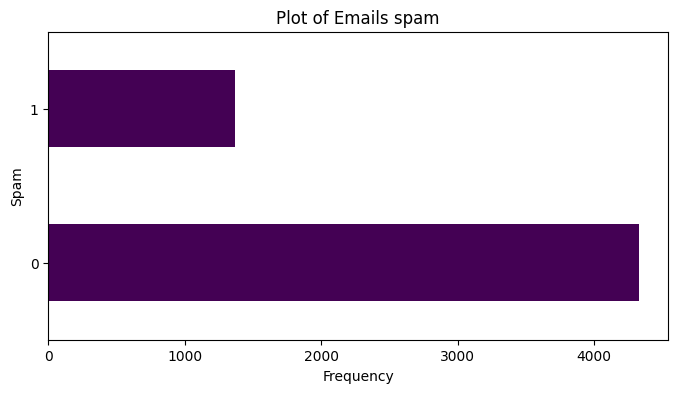

In [13]:
# Plot of of spam of emails
df["spam"].value_counts().plot(kind="barh", title="Plot of Emails spam",
                               xlabel="Frequency", ylabel="Spam",colormap='viridis',
                               figsize=(8,4));

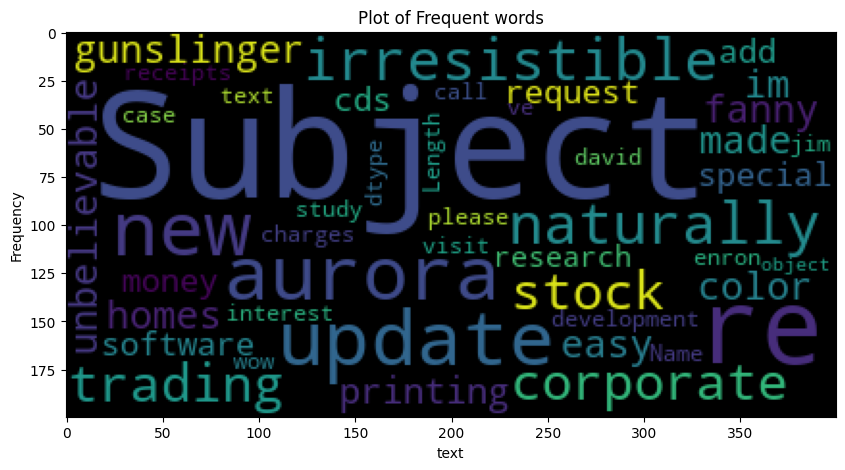

In [14]:
# Plot the frequent word on wordcloud
plot_freq_word(data=df, feature="text", title="Frequent words")

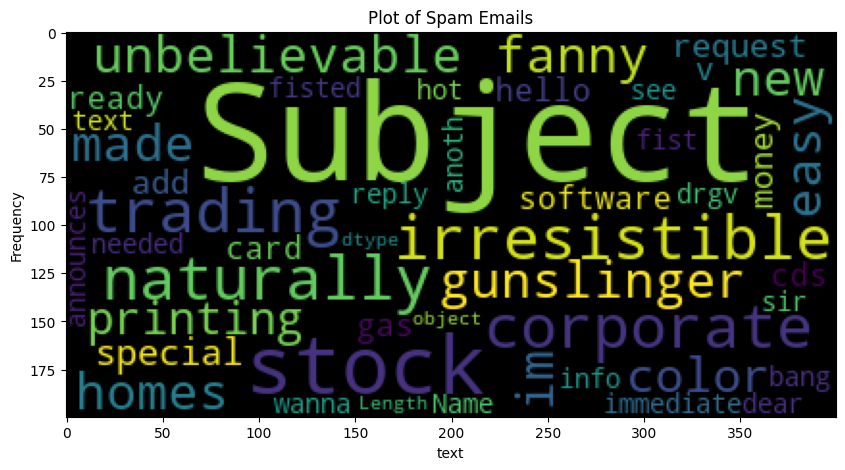

In [15]:
# Plot for spam message
mask = df["spam"] == 1
spam_text = df[mask]
plot_freq_word(data=spam_text, feature="text", title="Spam Emails")

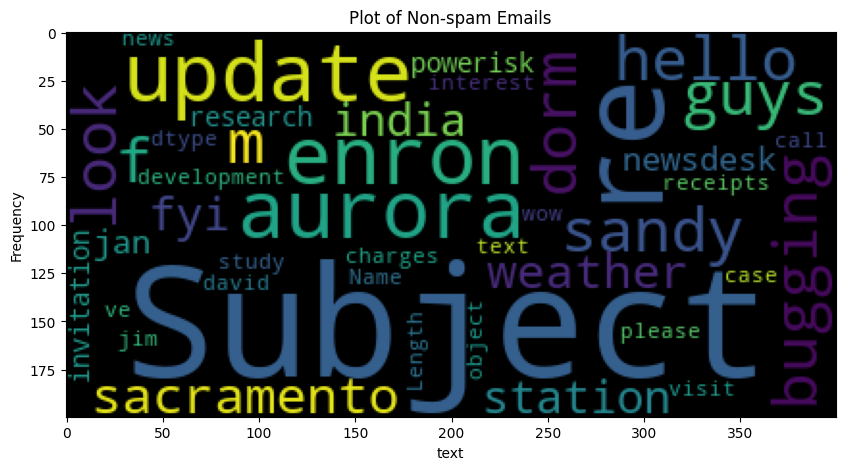

In [16]:
# Plot for no spam message
mask2 = df["spam"] == 0
no_spam_text = df[mask2]
plot_freq_word(data=no_spam_text,feature="text", title="Non-spam Emails")

### Split dataset

**NB:**

The `spam` variable is the `target or label variable`, while the `vectorized text` variable is the `feature variable / matrix`.

In [17]:
# Selecting the feature variable and the target vector or label variable
X = vectorizer
y = df["spam"]

In [18]:
# Split dataset into feature and label (target) variables
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [19]:
# Investigate the shape of the data
X.shape

(5693, 37103)

## Build Model



### Baseline Model

In [20]:
baseline_acc = y_train.value_counts(normalize=True).max()
print(f"Baseline accuracy: {round(baseline_acc,4)}")

Baseline accuracy: 0.7648


### Train Model

In [21]:
# Instantiate the fit the model on train dataset
model_clf = MultinomialNB().fit(X_train, y_train)

In [22]:
# Predict with the train dataset
y_train_pred = predict_label(X=X_train, model=model_clf)
y_train_pred

array([0, 1, 0, ..., 0, 0, 1])

In [23]:
print(f"Shape of y_train and y_pred: {y_train.shape, y_train_pred.shape}")

Shape of y_train and y_pred: ((4554,), (4554,))


In [24]:
# Compare true and predicted label variables
predicted_result(y_true=y_train, y_pred=y_train_pred)[:10]

,y_true,y_pred,error_term
2864,0,0,0
43,1,1,0
1892,0,0,0
3203,0,0,0
5103,0,0,0
5006,0,0,0
1071,1,1,0
718,1,1,0
4146,0,0,0
4797,0,0,0


In [25]:
# Get probability score
y_train_proba = proba_test_score(model=model_clf, X=X_train)

In [26]:
clf_report = classification_report(y_train, y_train_pred)
print(clf_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3483
           1       0.99      1.00      0.99      1071

    accuracy                           1.00      4554
   macro avg       0.99      1.00      1.00      4554
weighted avg       1.00      1.00      1.00      4554



In [27]:
# Evaluate the model performance on train dataset
eval_metrics(y_true=y_train, y_pred=y_train_pred, y_proba=y_train_proba)

{'accuracy': 0.9971, 'precision': 0.9898, 'recall': 0.9981, 'entropy': 0.0283}

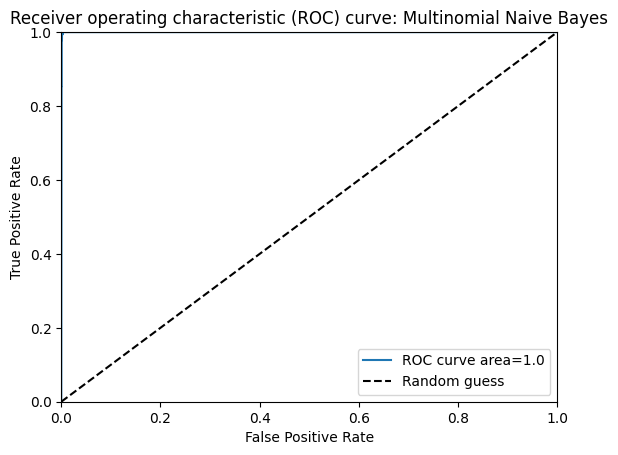

In [28]:
# Get the curve
get_auc_roc_curve(y=y_train, y_proba=y_train_proba,model_name="Multinomial Naive Bayes")

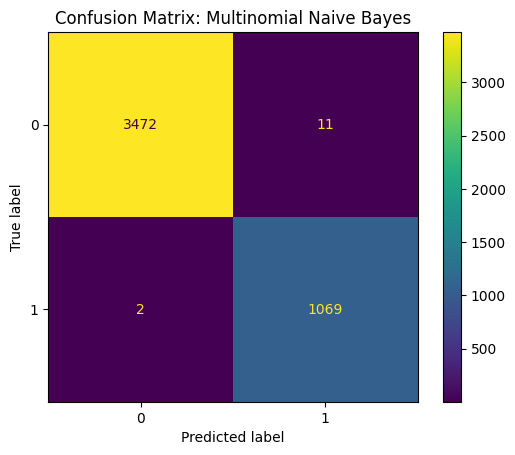

In [29]:
# Get the confusion matrix
confusion_mat(model=model_clf, X=X_train, y=y_train, model_name="Multinomial Naive Bayes")

### Evaluate Model

In [30]:
# Predict with the test dataset
y_test_pred = predict_label(X=X_test, model=model_clf)

In [31]:
# Compare true and predicted label variables
predicted_result(y_true=y_test, y_pred=y_test_pred)[:10]

,y_true,y_pred,error_term
1437,0,0,0
748,1,1,0
3472,0,0,0
1449,0,0,0
5682,0,0,0
944,1,1,0
1596,0,0,0
1667,0,0,0
2383,0,0,0
5288,0,0,0


In [32]:
clf_report = classification_report(y_test, y_test_pred)
print(clf_report)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       843
           1       0.97      0.99      0.98       296

    accuracy                           0.99      1139
   macro avg       0.98      0.99      0.99      1139
weighted avg       0.99      0.99      0.99      1139



In [33]:
# Get probability score
y_test_proba = proba_test_score(model=model_clf, X=X_test)

In [34]:
# Evaluate the model performance on test dataset
eval_metrics(y_true=y_test, y_pred=y_test_pred, y_proba=y_test_proba)

{'accuracy': 0.9903, 'precision': 0.9703, 'recall': 0.9932, 'entropy': 0.2522}

In [35]:
# Instantiate models
# Logit model
model_logit = LogisticRegression(random_state=42).fit(X_train, y_train)

# Decision Tree Classifier
model_dclf = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

# RandomForest Classifier
model_rfc = RandomForestClassifier(random_state=42, n_estimators=150,criterion="gini",
                                   max_depth=10).fit(X_train, y_train)

# KNeighborsClassifier
model_knc = KNeighborsClassifier(n_neighbors=5,weights="uniform",
                                 metric="minkowski").fit(X_train, y_train)

# SVC
model_svc = SVC(kernel="linear").fit(X_train, y_train)

In [36]:
# Evaluate performance of models
eval_best_model(model_1=model_clf, model_2=model_logit, 
                model_3=model_dclf, model_4=model_rfc, model_5=model_knc, 
                model_6=model_svc,X_train=X_train, X_test=X_test, 
                y_train=y_train, y_test=y_test)

Model accuracy for:MultinomialNB()
Training Accuracy: 0.9971
Test Accuracy: 0.9903
Model accuracy for:LogisticRegression(random_state=42)
Training Accuracy: 1.0
Test Accuracy: 0.993
Model accuracy for:DecisionTreeClassifier(random_state=42)
Training Accuracy: 1.0
Test Accuracy: 0.9658
Model accuracy for:RandomForestClassifier(max_depth=10, n_estimators=150, random_state=42)
Training Accuracy: 0.8428
Test Accuracy: 0.8139
Model accuracy for:KNeighborsClassifier()
Training Accuracy: 0.9295
Test Accuracy: 0.9043
Model accuracy for:SVC(kernel='linear')
Training Accuracy: 1.0
Test Accuracy: 0.9781


## Communicate Result

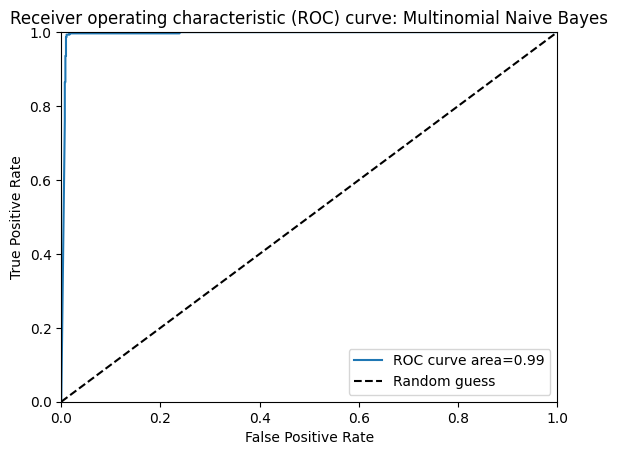

In [37]:
# Get the curve
get_auc_roc_curve(y=y_test, y_proba=y_test_proba,model_name="Multinomial Naive Bayes")

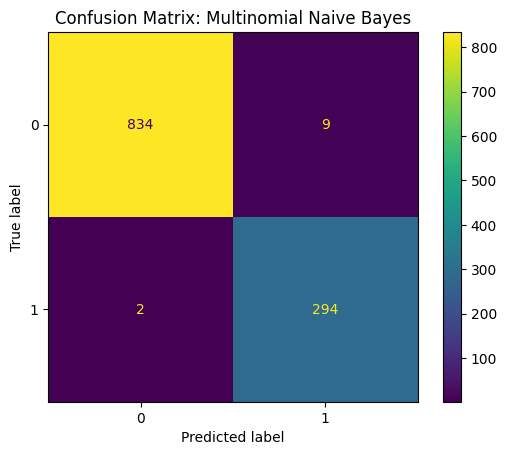

In [38]:
# Get the confusion matrix
confusion_mat(model=model_clf, X=X_test, y=y_test, model_name="Multinomial Naive Bayes")

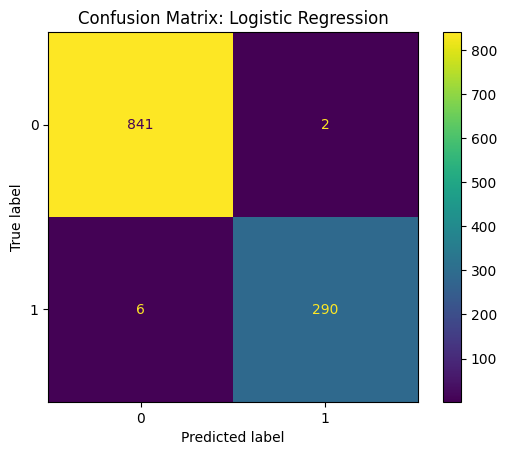

In [39]:
# Checking the performance of logit model with confusion matrix
confusion_mat(model=model_logit, X=X_test, y=y_test, model_name="Logistic Regression")

### Save Model

In [40]:
save_model( model=model_clf, filename="model_clf_nlp")
save_model( model=model_logit, filename="model_logit_nlp")